# 3b. Machine learning with satellite features - India

In [1]:
import json
import sys
from IPython.display import clear_output
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.isotonic import IsotonicRegression

from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm
import seaborn as sns
import matplotlib.ticker as mtick
from scipy.stats import sem, ttest_ind, spearmanr
import warnings
from multiprocessing import Pool
warnings.filterwarnings('ignore')

import scipy.stats
from shapely import wkt

def clean_plot(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    plt.tight_layout()

In [2]:
# RUN THIS CELL FOR US PUMAS
FEATURES_FNAME = '/data/mosaiks/features/mosaiks_features_by_puma_us.csv'
LABELS_FNAME = '/data/mosaiks/surveys/us/groundtruth_by_puma_2019.csv'
INDIVIDUAL_FNAME = '/data/mosaiks/surveys/us/individual_level_data.csv'
MERGE_KEYS = ['PUMA', 'State']
SPLIT_KEY = 'State'
TARGET = 'pop_density' # Use 'FINCP' for income experiment or 'pop_density' for pop density experiment
WEIGHT = 'PWGTP'
OUTFILE_NAME = '/data/mosaiks/simulations/us/population_density.json'
PERCENTILE_TARGETING = 20
FAIRNESS_VARS = ['rural']
ALPHAS = np.logspace(-3, 3, 10)

In [3]:
# RUN THIS CELL FOR TOGO CANTONS
FEATURES_FNAME = '/data/mosaiks/features/mosaiks_features_by_canton_togo.csv'
LABELS_FNAME = '/data/mosaiks/surveys/togo/groundtruth_by_canton.csv'
INDIVIDUAL_FNAME = '/data/mosaiks/surveys/togo/individual_level_data.csv'
MERGE_KEYS = ['Id']
SPLIT_KEY = 'Situation_'
TARGET = 'pop_density' # Use 'cons_basket' for cons experiment or 'pop_density' for pop density experiment
WEIGHT = 'weight'
OUTFILE_NAME = '/data/mosaiks/simulations/togo/population.json'
PERCENTILE_TARGETING = 20
FAIRNESS_VARS = ['rural']
ALPHAS = np.logspace(-3, 3, 10)

In [4]:
# RUN THIS CELL FOR SHRUG states
FEATURES_FNAME = '/data/mosaiks/shrug/shrug_nl_dmsp_2012.csv'
#FEATURES_FNAME = '/data/mosaiks/shrug/shrug_nl_viirs_2020.csv'
LABELS_FNAME = '/data/mosaiks/shrug/shrug.csv'
# INDIVIDUAL_FNAME = '/data/mosaiks/surveys/togo/individual_level_data.csv'
indiv_eval = False
MERGE_KEYS = ['shrid']
SPLIT_KEY = 'state'
TARGET = 'secc_cons_pc_combined' # Use 'cons_basket' for cons experiment or 'pop_density' for pop density experiment
WEIGHT = 'dummy_ones'
OUTFILE_NAME = '/data/mosaiks/simulations/shrug_test.json'
PERCENTILE_TARGETING = 20
FAIRNESS_VARS = ['rural']
ALPHAS = np.logspace(-3, 6, 10)


In [6]:
# Load and merge data
features = pd.read_csv(FEATURES_FNAME)
print('Regions with features: %i' % len(features))
labels = pd.read_csv(LABELS_FNAME)
print('Regions with labels: %i' % len(labels))
df = labels.merge(features, on=MERGE_KEYS, how='inner')
print('Regions with features and labels: %i' % len(df))
#feature_cols = [c for c in df.columns if 'Feature' in c]
feature_cols = ['dmsp_mean_light_2012_y']
#feature_cols = ['viirs_mean_light_2020_y']

Regions with features: 525868
Regions with labels: 525868
Regions with features and labels: 525868


In [8]:
df[feature_cols].max()

dmsp_mean_light_2012_y    63.0
dtype: float64

In [9]:
gdf = gpd.GeoDataFrame(df)
gdf['geometry'] = gdf['geometry'].apply(wkt.loads)
gdf = gdf.set_crs('EPSG:4326')

<AxesSubplot:>

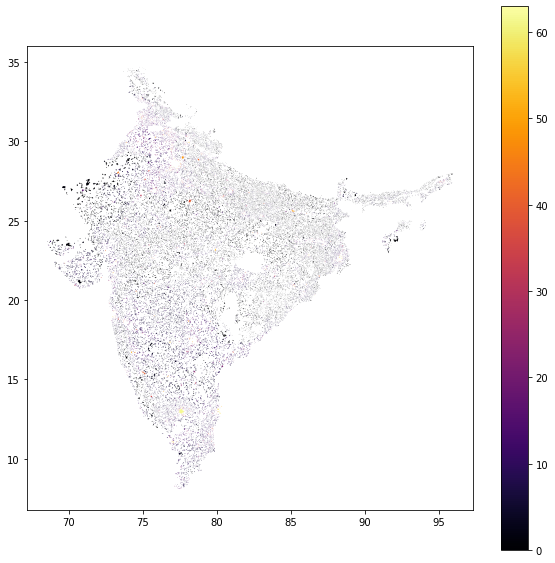

In [10]:
fig, ax = plt.subplots(figsize=(10,10))

gdf.sample(int(.1*len(gdf))).plot(column=feature_cols[0],ax=ax,cmap='inferno',legend=True)
#plt.colorbar()

In [11]:
df_nonzero_nl = df.loc[df[feature_cols[0]] != 0]
df_plot = df#.loc[np.log(1+df[TARGET])<=11]

Text(0.5, 1.0, 'Pearson r: 0.37')

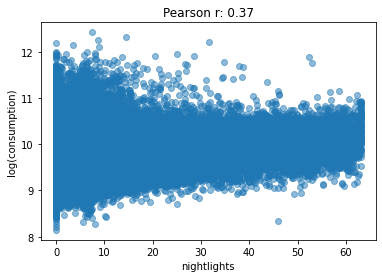

In [13]:
plt.scatter(df_plot[feature_cols],np.log(1+df_plot[TARGET]),alpha=0.5)
plt.xlabel('nightlights')
plt.ylabel('log(consumption)')
plt.title(f'Pearson r: {scipy.stats.pearsonr(np.log(1+df_plot[TARGET]),df_plot[feature_cols])[0][0]:.2f}')

In [69]:
# Preprocess MOSAIKS features: drop columns with all nulls or all same value, standardize
# for col in feature_cols:
#     cols_to_drop = []
#     if df[col].isnull().sum() == len(df) or df[col].std() == 0:
#         cols_to_drop.append(col)
#     else:
#         df[col] = (df[col] - df[col].mean())/df[col].std()
# df = df.drop(cols_to_drop, axis=1)

In [70]:
# Load individual data
if indiv_eval:
    indiv = pd.read_csv(INDIVIDUAL_FNAME)

In [76]:
def simulation(args,indiv_eval=False):
    i, df = args
    print('Simulation %i' % i, end='\r')
    np.random.seed(i)
    
    # Assign each state to train or test
    states = list(df[SPLIT_KEY].unique())
    train_states, test_states = train_test_split(states, test_size=0.25, random_state=i)
    train = df[df[SPLIT_KEY].isin(train_states)]
    test = df[df[SPLIT_KEY].isin(test_states)]
    x_train, x_test = train[feature_cols], test[feature_cols]
    y_train, y_test = np.log(train[TARGET]+1), np.log(test[TARGET] + 1)
    
    # Fit and predict with Ridge regression
    #model = RidgeCV(alphas=ALPHAS)
    model = IsotonicRegression( out_of_bounds='clip')
    model.fit(x_train, y_train)
 #   print(model.alpha_)
    yhat_train = model.predict(x_train)
    yhat_test = model.predict(x_test)
    
    # Put data in pandas dataframe
    data = test.copy()
    data['y'] = y_test
    data['yhat'] = yhat_test
    mse = np.mean(((np.array(yhat_test) - np.array(y_test))**2))
    data['y_noised'] = np.array(y_test) + np.random.normal(0, np.sqrt(mse), len(y_test))
    data['error'] = data['yhat'] - data['y']
    data['percent_error'] = data['error']/data['y']
    data['error_noised'] = data['y_noised'] - data['y']
    data['percent_error_noised'] = data['error_noised']/data['y']

    # Calculate r2 scores and MAE -- overall and by group
    results_predicted, results_noised = {}, {}
    results_predicted['r2_overall'] = r2_score(data['y'], data['yhat'])
    results_noised['r2_overall'] = r2_score(data['y'], data['y_noised'])
    results_predicted['pearson_overall'] = np.corrcoef(data['y'], data['yhat'])[0][1]
    results_noised['pearson_overall'] = np.corrcoef(data['y'], data['y_noised'])[0][1]
    results_predicted['spearman_overall'] = spearmanr(data['y'], data['yhat'])[0]
    results_noised['spearman_overall'] = spearmanr(data['y'], data['y_noised'])[0]
    results_predicted['mae_overall'] = data['error'].mean()
    results_noised['mae_overall'] = data['error_noised'].mean()
    
    for var in FAIRNESS_VARS:
        
        # Identify groups for variable: above or below median 
        if var == 'rural':
            above_median = data[data[var] == 1]
            below_median = data[data[var] == 0]
        else:
            above_median = data[data[var] >= np.median(data[var])]
            below_median = data[data[var] < np.median(data[var])]
        
        # Calculate r2, pearson, spearman and MAE by group 
        results_predicted['r2_above_' + var] = r2_score(above_median['y'], above_median['yhat'])
        results_predicted['r2_below_' + var] = r2_score(below_median['y'], below_median['yhat'])
        results_noised['r2_above_' + var] = r2_score(above_median['y'], above_median['y_noised'])
        results_noised['r2_below_' + var] = r2_score(below_median['y'], below_median['y_noised'])
        results_predicted['pearson_above_' + var] = np.corrcoef(above_median['y'], above_median['yhat'])[0][1]
        results_predicted['pearson_below_' + var] = np.corrcoef(below_median['y'], below_median['yhat'])[0][1]
        results_noised['pearson_above_' + var] = np.corrcoef(above_median['y'], above_median['y_noised'])[0][1]
        results_noised['pearson_below_' + var] = np.corrcoef(below_median['y'], below_median['y_noised'])[0][1]
        results_predicted['spearman_above_' + var] = spearmanr(above_median['y'], above_median['yhat'])[0]
        results_predicted['spearman_below_' + var] = spearmanr(below_median['y'], below_median['yhat'])[0]
        results_noised['spearman_above_' + var] = spearmanr(above_median['y'], above_median['y_noised'])[0]
        results_noised['spearman_below_' + var] = spearmanr(below_median['y'], below_median['y_noised'])[0]
        results_predicted['mae_above_' + var] = above_median['error'].mean()
        results_predicted['mae_below_' + var] = below_median['error'].mean()
        results_noised['mae_above_' + var] = above_median['error_noised'].mean()
        results_noised['mae_below_' + var] = below_median['error_noised'].mean()
    
    # Targeting simulation
    if 'pop_density' not in TARGET and indiv_eval:
        y = data['y'].values.flatten()
        yhat = data['yhat'].values.flatten()
        y_noised = data['y_noised'].values.flatten()
        ids = test[MERGE_KEYS].values

        curve1, curve2, curve3 = [], [], []
        grid = np.arange(3, 101, 1)
        for p, percentile in enumerate(grid):

            # Get cut-off value for predicted, true, and noised versions of labels
            prediction_thresh = np.percentile(yhat, percentile)
            true_thresh = np.percentile(y, percentile)
            noised_thresh = np.percentile(y_noised, percentile)

            # Identify regions below cut-off value
            prediction_pumas = pd.DataFrame(ids[(yhat < prediction_thresh).nonzero()[0]], columns=MERGE_KEYS)
            true_pumas = pd.DataFrame(ids[(y < true_thresh).nonzero()[0]], columns = MERGE_KEYS)
            noised_pumas = pd.DataFrame(ids[(y_noised < noised_thresh).nonzero()[0]], columns = MERGE_KEYS)
            prediction_pumas = prediction_pumas.merge(df, on=MERGE_KEYS, how='inner')
            true_pumas = true_pumas.merge(df, on=MERGE_KEYS, how='inner')
            noised_pumas = noised_pumas.merge(df, on=MERGE_KEYS, how='inner')

            # Identify individuals in regions below the cut-off value
            
            test_indiv = test[MERGE_KEYS].merge(indiv, on=MERGE_KEYS, how='inner')
            prediction_pumas_indiv = prediction_pumas[MERGE_KEYS].merge(indiv, on=MERGE_KEYS, how='inner')
            true_pumas_indiv = true_pumas[MERGE_KEYS].merge(indiv, on=MERGE_KEYS, how='inner')
            noised_pumas_indiv = noised_pumas[MERGE_KEYS].merge(indiv, on=MERGE_KEYS, how='inner')

            for var in FAIRNESS_VARS:

                # At initialization, set up lists to record curves
                if p == 0:
                    results_predicted['alloc_curve_true_' + var] = []
                    results_predicted['alloc_curve_proxy_' + var] = []
                    results_noised['alloc_curve_true_' + var] = []
                    results_noised['alloc_curve_proxy_' + var] = []
                    results_predicted['recall_curve_true_' + var] = []
                    results_predicted['recall_curve_proxy_' + var] = []
                    results_noised['recall_curve_true_' + var] = []
                    results_noised['recall_curve_proxy_' + var] = []

                # Record allocation to each group at percentile                     
                alloc_true = 100*((true_pumas[var]*true_pumas[WEIGHT]).sum()/true_pumas[WEIGHT].sum()) 
                alloc_proxy = 100*((prediction_pumas[var]*prediction_pumas[WEIGHT]).sum()/\
                                   prediction_pumas[WEIGHT].sum())
                alloc_noised = 100*((noised_pumas[var]*noised_pumas[WEIGHT]).sum()/noised_pumas[WEIGHT].sum())
                results_predicted['alloc_curve_true_' + var].append(alloc_true)
                results_predicted['alloc_curve_proxy_' + var].append(alloc_proxy)
                results_noised['alloc_curve_true_' + var].append(alloc_true)
                results_noised['alloc_curve_proxy_' + var].append(alloc_noised)

                # Record recall for each group at percentile
                recalls = []
                for indiv_num in [true_pumas_indiv, prediction_pumas_indiv, noised_pumas_indiv]:
                    denominator = test_indiv[(test_indiv[var] == 1) & (test_indiv['poor'] == 1)][WEIGHT].sum()
                    numerator = indiv_num[(indiv_num[var] == 1) & (indiv_num['poor'] == 1)][WEIGHT].sum()
                    recalls.append(100*numerator/denominator)
                results_predicted['recall_curve_true_' + var].append(recalls[0])
                results_predicted['recall_curve_proxy_' + var].append(recalls[1])
                results_noised['recall_curve_true_' + var].append(recalls[0])
                results_noised['recall_curve_proxy_' + var].append(recalls[2])

                # Record allocations and recall separately if this is the threshold of interest
                if percentile == PERCENTILE_TARGETING:
                    results_predicted['alloc_true_' + var] = alloc_true
                    results_predicted['alloc_proxy_' + var] = alloc_proxy
                    results_noised['alloc_true_' + var] = alloc_true
                    results_noised['alloc_proxy_' + var] = alloc_noised
                    results_predicted['recall_true_' + var] = recalls[0]
                    results_predicted['recall_proxy_' + var] = recalls[1]
                    results_noised['recall_true_' + var] = recalls[0]
                    results_noised['recall_proxy_' + var] = recalls[2]
    elif indiv_eval:
        # Representation assignment simulation
        for var in FAIRNESS_VARS:

            # Identify groups for variable: above or below median 
            if var == 'rural':
                above_median = data[data[var] == 1]
                below_median = data[data[var] == 0]
            else:
                above_median = data[data[var] >= np.median(data[var])]
                below_median = data[data[var] < np.median(data[var])]

            results_predicted['alloc_above_' + var] = (above_median['Area']*above_median['yhat']).sum()/\
                (above_median['Area']*above_median['y']).sum()
            results_noised['alloc_above_' + var] = (above_median['Area']*above_median['y_noised']).sum()/\
                (above_median['Area']*above_median['y']).sum()
            results_predicted['alloc_below_' + var] = (below_median['Area']*below_median['yhat']).sum()/\
                (below_median['Area']*below_median['y']).sum()
            results_noised['alloc_below_' + var] = (below_median['Area']*below_median['y_noised']).sum()/\
                (below_median['Area']*below_median['y']).sum()
            

    return results_predicted, results_noised

In [77]:
n_trials = 100
results_nl = []
for i in range(n_trials):
    results_nl.append(simulation((i,df),indiv_eval=False))

with open(OUTFILE_NAME, 'w') as outfile:
    json.dump(results_nl, outfile)

In [78]:
key = 'r2_overall'
print(np.mean([r[0][key] for r in results_nl]))

-0.11235962153309076


In [13]:
OUTFILE_NAME = 'shrug_test.json'
 
pool = Pool(50)
results = pool.map(simulation, [(i, df, indiv_eval) for i in range(100)])
with open(OUTFILE_NAME, 'w') as outfile:
    json.dump(results, outfile)
clear_output(wait=True)
print('Done!', end='\r')

Process ForkPoolWorker-33:
Process ForkPoolWorker-47:
Process ForkPoolWorker-20:
Process ForkPoolWorker-28:
Process ForkPoolWorker-41:
Process ForkPoolWorker-1:
Process ForkPoolWorker-38:
Process ForkPoolWorker-31:
Process ForkPoolWorker-35:
Process ForkPoolWorker-37:
Process ForkPoolWorker-12:
Process ForkPoolWorker-4:
Process ForkPoolWorker-26:
Process ForkPoolWorker-7:
Process ForkPoolWorker-44:
Process ForkPoolWorker-43:
Process ForkPoolWorker-36:
Process ForkPoolWorker-50:
Process ForkPoolWorker-45:
Process ForkPoolWorker-25:
Process ForkPoolWorker-39:
Process ForkPoolWorker-9:
Process ForkPoolWorker-27:
Process ForkPoolWorker-34:
Process ForkPoolWorker-32:
Process ForkPoolWorker-42:
Process ForkPoolWorker-16:
Process ForkPoolWorker-23:
Process ForkPoolWorker-14:
Process ForkPoolWorker-19:
Process ForkPoolWorker-3:
Process ForkPoolWorker-22:
Process ForkPoolWorker-17:
Process ForkPoolWorker-13:
Process ForkPoolWorker-10:
Process ForkPoolWorker-24:
Process ForkPoolWorker-40:
Proces

  File "/home/erolf/.conda/envs/siml/lib/python3.10/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/erolf/.conda/envs/siml/lib/python3.10/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/erolf/.conda/envs/siml/lib/python3.10/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/erolf/.conda/envs/siml/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/erolf/.conda/envs/siml/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/erolf/.conda/envs/siml/lib/python3.10/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/erolf/.conda/envs/siml/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/erolf/.conda/envs/siml/lib/python3.10/multiprocessing/process.py", line 10

  File "/home/erolf/.conda/envs/siml/lib/python3.10/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/home/erolf/.conda/envs/siml/lib/python3.10/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/home/erolf/.conda/envs/siml/lib/python3.10/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/home/erolf/.conda/envs/siml/lib/python3.10/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/home/erolf/.conda/envs/siml/lib/python3.10/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/home/erolf/.conda/envs/siml/lib/python3.10/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/home/erolf/.conda/envs/siml/lib/python3.10/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/home/erolf/.conda/envs/siml/lib/python3.10/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/home/erolf/.conda/envs/siml/lib/python3.10/multiprocessing/pool.py", li

  File "/home/erolf/.conda/envs/siml/lib/python3.10/multiprocessing/queues.py", line 365, in get
    with self._rlock:
  File "/home/erolf/.conda/envs/siml/lib/python3.10/multiprocessing/queues.py", line 365, in get
    with self._rlock:
  File "/home/erolf/.conda/envs/siml/lib/python3.10/multiprocessing/queues.py", line 365, in get
    with self._rlock:
  File "/home/erolf/.conda/envs/siml/lib/python3.10/multiprocessing/queues.py", line 365, in get
    with self._rlock:
  File "/home/erolf/.conda/envs/siml/lib/python3.10/multiprocessing/queues.py", line 365, in get
    with self._rlock:
  File "/home/erolf/.conda/envs/siml/lib/python3.10/multiprocessing/queues.py", line 365, in get
    with self._rlock:
  File "/home/erolf/.conda/envs/siml/lib/python3.10/multiprocessing/queues.py", line 365, in get
    with self._rlock:
  File "/home/erolf/.conda/envs/siml/lib/python3.10/multiprocessing/queues.py", line 365, in get
    with self._rlock:
  File "/home/erolf/.conda/envs/siml/lib/python3

  File "/home/erolf/.conda/envs/siml/lib/python3.10/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/erolf/.conda/envs/siml/lib/python3.10/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/erolf/.conda/envs/siml/lib/python3.10/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/erolf/.conda/envs/siml/lib/python3.10/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/erolf/.conda/envs/siml/lib/python3.10/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/erolf/.conda/envs/siml/lib/python3.10/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/erolf/.conda/envs/siml/lib/python3.10/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__en

NameError: name 'OUTFILE_NAME' is not defined